# YouTube channel comparison 2019-2015

This Notebook implements a series of analyses to compare the (almost) full YouTube channel populations with at least 1k subscribers between 2019 and 2025. The channel data was collected based on two exhaustive crawls in 2019 and 2025. Everything is this notebook is based on the comparison of per-channel data, not on videos.

In [ ]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

pd.set_option('display.max_rows', None)

con_2019 = duckdb.connect('/Users/rieder/Desktop/YT/youtube_all_channels_2019.duckdb')
con_2025 = duckdb.connect('/Users/rieder/Desktop/YT/youtube_all_channels_v5.duckdb')

#con_2019 = duckdb.connect('D:/YT/Crawl 2025/youtube_all_channels_2019.duckdb')
#con_2025 = duckdb.connect('D:/YT/Crawl 2025/youtube_all_channels_v5.duckdb')

## Available SQL columns

Overview of the fields available in the two used databases.

### 2019

In [2]:
con_2019.execute("""PRAGMA table_info('channels');""").fetchdf()

,cid,name,type,notnull,dflt_value,pk
0,0,id,VARCHAR,False,None,False
1,1,title,VARCHAR,False,None,False
2,2,description,VARCHAR,False,None,False
3,3,subscriberCount,BIGINT,False,None,False
4,4,videoCount,BIGINT,False,None,False
5,5,commentCount,BIGINT,False,None,False
6,6,viewCount,BIGINT,False,None,False
7,7,featuring,BIGINT,False,None,False
8,8,subscribing,BIGINT,False,None,False
9,9,country,VARCHAR,False,None,False


### 2025

In [3]:
con_2025.execute("""PRAGMA table_info('channels');""").fetchdf()

,cid,name,type,notnull,dflt_value,pk
0,0,id,VARCHAR,True,None,True
1,1,title,VARCHAR,False,None,False
2,2,description,VARCHAR,False,None,False
3,3,customUrl,VARCHAR,False,None,False
4,4,subscriberCount,BIGINT,False,None,False
5,5,hiddenSubscriberCount,BOOLEAN,False,None,False
6,6,videoCount,BIGINT,False,None,False
7,7,viewCount,BIGINT,False,None,False
8,8,country,VARCHAR,False,None,False
9,9,publishedAt,TIMESTAMP,False,None,False


## Statistical overview

### Basic descriptive statistics (including five-point summary)

In [4]:
cutoff = 1000
pd.options.display.float_format = '{:,.1f}'.format


df_quant_2019 = con_2019.execute(f"""
SELECT subscriberCount,videoCount,viewCount,daysactive,featuring,subscribing FROM channels
WHERE subscriberCount >= {cutoff} AND daysactive < 20000    
""").fetchdf()

df_quant_2019 = df_quant_2019.fillna(0)
df_quant_2019["viewCount_per_video"] = np.where(df_quant_2019["videoCount"] > 0, df_quant_2019["viewCount"] / df_quant_2019["videoCount"], 0)
print("Descriptive statistics for channels in 2019:")
display(df_quant_2019.describe())


df_quant_2025 = con_2025.execute(f"""
SELECT subscriberCount,videoCount,viewCount,daysactive,featuring,subscribing FROM channels
WHERE in_2025_sample = true AND subscriberCount >= {cutoff} AND daysactive < 20000
""").fetchdf()

df_quant_2025 = df_quant_2025.fillna(0)
df_quant_2025["viewCount_per_video"] = np.where(df_quant_2025["videoCount"] > 0, df_quant_2025["viewCount"] / df_quant_2025["videoCount"], 0)
print("Descriptive statistics for channels in 2025:")
display(df_quant_2025.describe())

Descriptive statistics for channels in 2019:


,subscriberCount,videoCount,viewCount,daysactive,featuring,subscribing,viewCount_per_video
count,"4,415,179.0","4,415,179.0","4,415,179.0","4,415,179.0","4,415,179.0","4,415,179.0","4,415,179.0"
mean,"25,707.7",178.9,"6,629,989.4","2,200.7",1.0,53.3,"156,509.0"
std,"289,560.6","1,749.6","120,136,416.1","1,231.0",3.0,154.8,"1,505,097.1"
min,"1,000.0",0.0,0.0,33.0,0.0,0.0,0.0
25%,"1,530.0",12.0,"106,800.0","1,182.0",0.0,0.0,"1,860.1"
50%,"2,850.0",40.0,"560,479.0","2,079.0",0.0,0.0,"9,775.9"
75%,"7,800.0",119.0,"2,102,700.0","3,045.0",1.0,17.0,"47,904.0"
max,"119,000,000.0","1,067,410.0","90,251,795,729.0","5,599.0",100.0,"1,000.0","727,781,394.5"


Descriptive statistics for channels in 2025:


,subscriberCount,videoCount,viewCount,daysactive,featuring,subscribing,viewCount_per_video
count,"22,079,674.0","22,079,674.0","22,079,674.0","22,079,674.0","22,079,674.0","22,079,674.0","22,079,674.0"
mean,"24,860.1",282.9,"8,849,513.4","2,532.7",0.4,50.5,"90,683.7"
std,"337,936.6","1,860.8","209,984,612.7","1,642.0",8.2,162.4,"3,069,117.9"
min,"1,000.0",0.0,0.0,4.0,0.0,0.0,0.0
25%,"1,520.0",22.0,"101,859.0","1,227.0",0.0,0.0,888.2
50%,"2,740.0",87.0,"413,474.0","2,133.0",0.0,0.0,"3,430.6"
75%,"7,210.0",261.0,"1,520,614.8","3,631.0",0.0,0.0,"17,482.3"
max,"442,000,000.0","2,915,145.0","313,520,492,555.0","7,698.0","19,106.0","1,000.0","9,372,719,868.0"


Findings:
* 4.4M 1k+ channels in 2019, 22M in 2025
* The distribution of subscriberCount is a little lower in 2025 (meaning more channels in the lower tiers, getting crowded there), but hasn't moved much. Mr. Beast (442M subscribers) is now a media organization.
* videoCount is much higher along the distribution, which is normal as channels continue to produce. This would be interesting to analyze on a "per year" basis, but this requires looking at different datasets.
* viewCount (per channel) has continued to climb, but the median and 75% have dropped, again hinting that the "success distribution" is more skewed in 2025.
* daysactive has evolved within expectations from what I can see.
* The **most important finding** here (IMO!) is the viewCount_per_video metric (calculated by dividing per-channel viewCount by videoCount), which has dropped like a stone (median collapsed by 65%) on all levels along the distribution. This means that videos are much more likely to underperform in 2025. We will have to investigate further with the videos dataset, including income calculations.

Summary: YouTube is getting increasingly crowded and per video success is much more difficult to attain. 

### Correlations

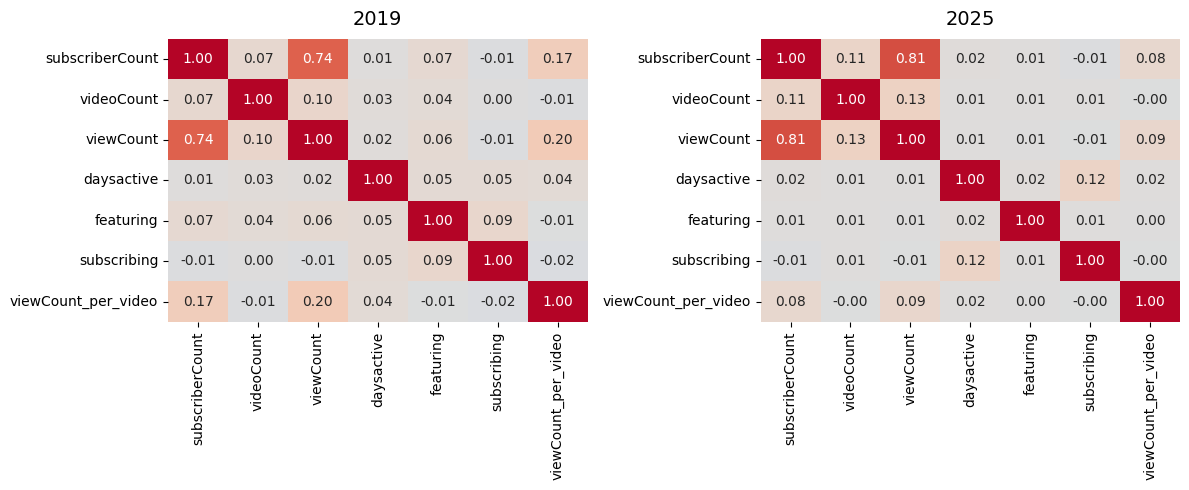

In [5]:
corr_2019 = df_quant_2019.corr()
corr_2025 = df_quant_2025.corr()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(corr_2019, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], vmin=-1, vmax=1, cbar=False)
axes[0].set_title('2019', fontsize=14, pad=10)

sns.heatmap(corr_2025, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1], vmin=-1, vmax=1, cbar=False)
axes[1].set_title('2025', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

Findings: This could profit from more in-depth interpretation, but what stands out for me is that subscriberCount and viewCount_per_video correlate less in 2025 that 2019, pointing towards the increasing importance of other pathways: ranking and recommendation (incl. Shorts shelf and TikTok-style Shorts feed), "organic" virality, etc.

## Country distribution

In [6]:
cutoff = 1000

df_2019 = con_2019.execute(f"""
    SELECT country, COUNT(*) as count, SUM(viewCount) as total_views FROM channels
    WHERE subscriberCount >= {cutoff}
    GROUP BY country
    ORDER BY count DESC
""").fetchdf()

df_2025 = con_2025.execute(f"""
    SELECT country, COUNT(*) as count, SUM(viewCount) as total_views FROM channels
    WHERE in_2025_sample = true AND subscriberCount >= {cutoff}
    GROUP BY country
    ORDER BY count DESC
""").fetchdf()

df_2019["percent count"] = df_2019['count'] / df_2019['count'].sum() * 100
df_2025["percent count"] = df_2025['count'] / df_2025['count'].sum() * 100

df_2019["percent views"] = df_2019['total_views'] / df_2019['total_views'].sum() * 100
df_2025["percent views"] = df_2025['total_views'] / df_2025['total_views'].sum() * 100

html_19 = df_2019.head(16).style.format(thousands=",", precision=1).hide().to_html()
html_25 = df_2025.head(16).style.format(thousands=",", precision=1).hide().to_html()

html = f"""
<div style="display:flex; gap:20px; align-items:flex-start">
    <div><b>2019</b> {html_19}</div>
    <div></div>
    <div><b>2025</b> {html_25}</div>
</div>
"""
display(HTML(html))

country,count,total_views,percent count,percent views
None,"2,367,581","10,574,100,190,243.0",53.6,36.1
US,"371,756","4,790,741,737,355.0",8.4,16.4
IN,"202,379","2,267,005,285,353.0",4.6,7.7
BR,"187,125","1,142,775,991,453.0",4.2,3.9
RU,"103,707","840,643,672,365.0",2.3,2.9
ID,"99,728","469,498,175,254.0",2.3,1.6
GB,"71,075","731,907,860,526.0",1.6,2.5
FR,"53,595","345,240,694,727.0",1.2,1.2
DE,"51,209","406,759,022,087.0",1.2,1.4
MX,"47,262","454,415,537,785.0",1.1,1.6


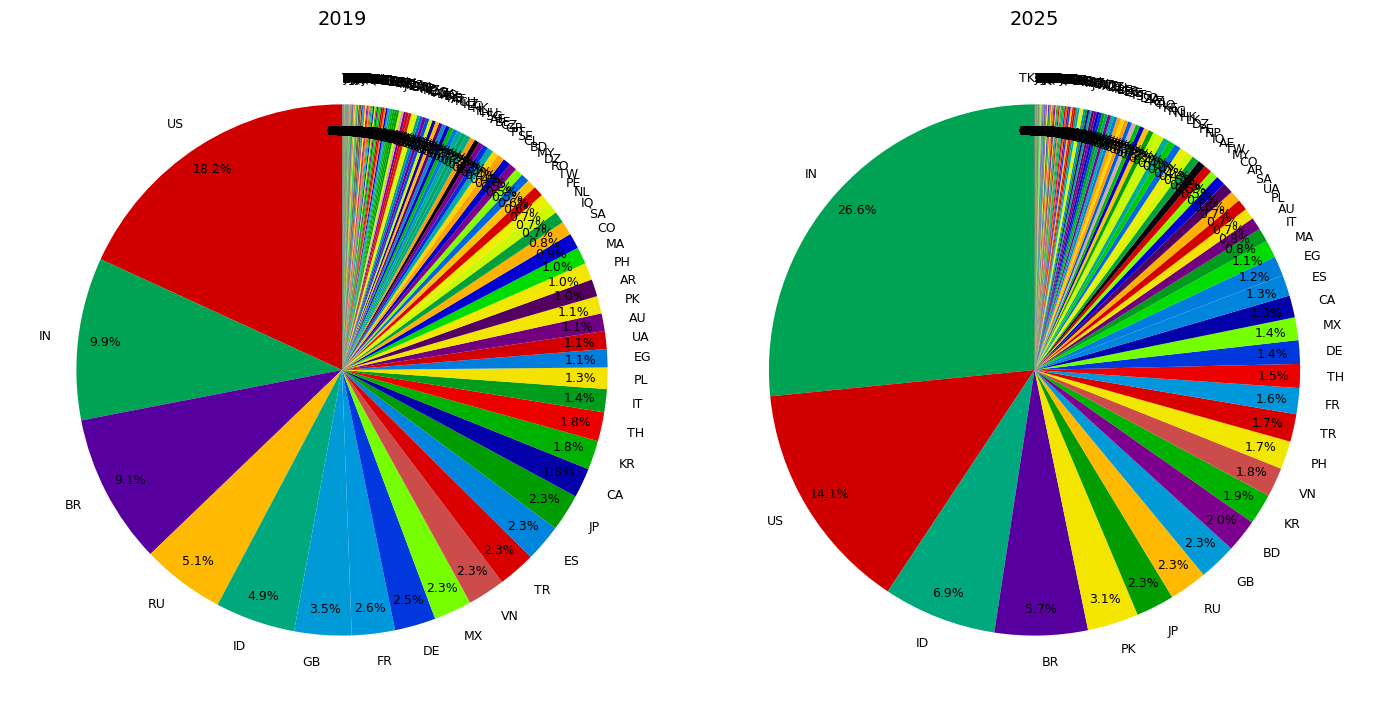

In [7]:

df_2019 = df_2019[df_2019['country'].notna()]
df_2025 = df_2025[df_2025['country'].notna()]

all_countries = sorted(set(df_2019['country']).union(set(df_2025['country'])))
num_countries = len(all_countries)

cmap = plt.get_cmap('nipy_spectral') 
colors = [cmap(i) for i in np.linspace(0, 1, num_countries)]
country_color_map = {country: colors[i] for i, country in enumerate(all_countries)}

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_2019 = [country_color_map[c] for c in df_2019['country']]
axes[0].pie(df_2019['count'], labels=df_2019['country'], colors=colors_2019, autopct='%1.1f%%', startangle=90, pctdistance=0.9, textprops={'fontsize': 9})
axes[0].set_title('2019', fontsize=14, pad=10)

colors_2025 = [country_color_map[c] for c in df_2025['country']]
axes[1].pie(df_2025['count'], labels=df_2025['country'], colors=colors_2025, autopct='%1.1f%%', startangle=90, pctdistance=0.9, textprops={'fontsize': 9})
axes[1].set_title('2025', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

Findings:
* There are fewer channels in 2025 without a channel flag (53.6% => 44.3%).
* While all countries have grown their channel polulations (from what I can see), some countries grew much faster, leading to a different ranking. Standing out are India (switched places with US wrt largest channel population, 9.9% => 26.6%), Indonesia (4.9% => 6.9%), and Pakistan (1.1% => 3.1%). Already more "saturated" countries have fallen back, like the US (18.2% => 14.1%), Brazil (9.1% => 5.7%), and Russia (5.1% => 2.3%); the same goes for European countries (GB, DE, ES, etc. all dropped in terms of percentages).
* This shift is less obvious for viewCount percentages, which is in part due to this being per-channel lifetime views, but even there, India has overtaken the US (18.2% vs 17.9%). If we were to limit this only to videos from, e.g., 2025, India would be much more dominant.
* One could add a lot more analyses here, even without adding any other datasets, e.g., intersecting the descriptive statistics above with country markers.

Summary: YouTube is continuing to become more non-Western, India now has the most channels and the most views.

## Inequality

This section looks at inequalities (using viewCount as it most directly links with monetization) through three different analytical lenses.

### Gini coefficient

Wikipedia:

> In economics, the Gini coefficient also known as the Gini index or Gini ratio, is a measure of statistical dispersion intended to represent the income inequality, the wealth inequality, or the consumption inequality within a nation or a social group. It was developed by Italian statistician and sociologist Corrado Gini. The Gini coefficient measures the inequality among the values of a frequency distribution, such as income levels. A Gini coefficient of 0 reflects perfect equality, where all income or wealth values are the same. In contrast, a Gini coefficient of 1 (or 100%) reflects maximal inequality among values, where a single individual has all the income while all others have none.

Here, income is basically expressed as views.

In [8]:
cutoff = 1000

def gini_coefficient_fast(x):
   
    x = np.asarray(x, dtype=np.float64).flatten()
    if len(x) == 0:
        return 0.0
    
    if np.amin(x) < 0:
        x -= np.amin(x) 
        
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    
    numerator = np.sum((2 * index - n - 1) * x)
    denominator = n * np.sum(x)
    
    if denominator == 0:
        return 0.0
        
    return (numerator / denominator).item()


data_2019 = con_2019.execute(f"SELECT viewCount FROM channels WHERE subscriberCount >= {cutoff}").fetchdf()['viewCount'].values
data_2025 = con_2025.execute(f"SELECT viewCount FROM channels WHERE subscriberCount >= {cutoff} AND in_2025_sample = true").fetchdf()['viewCount'].values

gini_2019 = gini_coefficient_fast(data_2019)
gini_2025 = gini_coefficient_fast(data_2025)

print(f"Gini Coefficient 2019: {gini_2019:.3f}")
print(f"Gini Coefficient 2025: {gini_2025:.3f}")

Gini Coefficient 2019: 0.905
Gini Coefficient 2025: 0.939


Findings: Gini goes up a bit from 2019 and is now extremely high. The subscriberCount filter already removes the most unsuccessful channels (without filter for 2025: 0.9821), but even with the filter, there is basically no "middle class". For comparison: the most unequal country in the world, South Africa, has a Gini of 0.63 for wealth distribution.

### Lorenz curve

Wikipedia:

> In economics, the Lorenz curve is a graphical representation of the distribution of income or of wealth. It was developed by Max Lorenz in 1905 for representing inequality of the wealth distribution. The curve is a graph showing the proportion of overall income or wealth assumed by the bottom x% of the people, [...]. It is often used to represent income distribution, where it shows for the bottom x% of households, what percentage (y%) of the total income they have. The percentage of households is plotted on the x-axis, the percentage of income on the y-axis. It can also be used to show distribution of assets. In such use, many economists consider it to be a measure of social inequality.

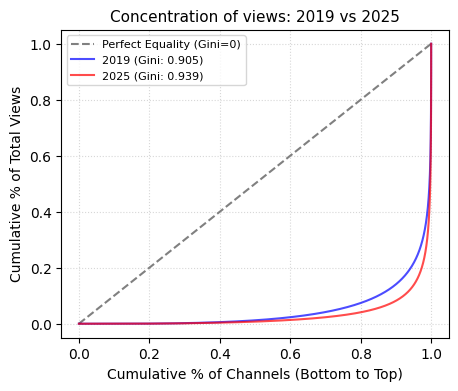

In [9]:
plt.figure(figsize=(5, 4))

# Function to calculate Lorenz components
def get_lorenz(data):
    scaled_data = np.sort(data)
    cum_data = np.cumsum(scaled_data)
    # Normalize to 0-1 range
    lorenz_y = cum_data / cum_data[-1]
    lorenz_x = np.linspace(0, 1, len(lorenz_y))
    return lorenz_x, lorenz_y

x19, y19 = get_lorenz(data_2019)
x25, y25 = get_lorenz(data_2025)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Equality (Gini=0)')

plt.plot(x19, y19, label=f'2019 (Gini: {gini_2019:.3f})', color='blue', alpha=0.7)
plt.plot(x25, y25, label=f'2025 (Gini: {gini_2025:.3f})', color='red', alpha=0.7)

plt.title('Concentration of views: 2019 vs 2025', fontsize=11)
plt.xlabel('Cumulative % of Channels (Bottom to Top)', fontsize=10)
plt.ylabel('Cumulative % of Total Views', fontsize=10)
plt.legend(loc='upper left', fontsize=8)
plt.grid(True, which='both', linestyle=':', alpha=0.5)

plt.show()

Findings: the Lorenz curve gives us more detail than Gini alone, and from the chart, we can indeed see a "thinning out" of the middle class, in line with what we have already seen for descriptive statistics. One way to explain this could be to say that the "elite" (in terms of view accumulation) has grown much slower than the overall channel population.

### Concentration as percent shares

Another way of expressing inequality, maybe easier to understand than Gini and Lorenz curves? This is basically Area under the Curve (AUC) from the Lorenz curve for three cutoffs.

In [10]:
def calculate_concentration(data, year_label):

    data = np.sort(data)[::-1]
    total_views = np.sum(data)
    n = len(data)
    
    top_1_percent_idx = max(1, int(n * 0.01))
    top_10_percent_idx = max(1, int(n * 0.10))
    top_20_percent_idx = max(1, int(n * 0.20))
    
    share_1 = (np.sum(data[:top_1_percent_idx]) / total_views) * 100
    share_10 = (np.sum(data[:top_10_percent_idx]) / total_views) * 100
    share_20 = (np.sum(data[:top_20_percent_idx]) / total_views) * 100
    
    print(f"Concentration {year_label}")
    print(f"Top 1% of creators hold:   {share_1:.1f}% of all views")
    print(f"Top 10% of creators hold:  {share_10:.1f}% of all views")
    print(f"Top 20% of creators hold:  {share_20:.1f}% of all views")
    
    return share_1, share_10, share_20

stats_2019 = calculate_concentration(data_2019, "2019")
print()
stats_2025 = calculate_concentration(data_2025, "2025")

Concentration 2019
Top 1% of creators hold:   59.1% of all views
Top 10% of creators hold:  85.9% of all views
Top 20% of creators hold:  92.6% of all views

Concentration 2025
Top 1% of creators hold:   68.2% of all views
Top 10% of creators hold:  91.8% of all views
Top 20% of creators hold:  95.9% of all views


Findings: just another view of what we have seen above, things have been getting even more unequal than they were before. Interesting: The percentage growth has been the highest for the 1%.

## Topics

Comparison of topic distribution. This is an attribution by YouTube (not creator selected, like videos). Using wikitopics since the older topics are no longer available. Not sure if the topic attribution works exactly the same now compared to 2019 (maybe investigate if topics changed for specific channels?).

NB: a channel can have more than one topic. The following calculations are based on x% of channels have a given category, so percentages do not add up to 100.

In [11]:
cutoff = 1000
pd.options.display.float_format = '{:,.1f}'.format

df_2019 = con_2019.execute(f"SELECT wikitopics FROM channels WHERE subscriberCount >= {cutoff}").fetchdf()
df_2025 = con_2025.execute(f"SELECT wikitopics FROM channels WHERE subscriberCount >= {cutoff} AND in_2025_sample = true").fetchdf()

def get_topic_stats(df):
    total_channels = len(df)
    
    df['wikitopics'] = df['wikitopics'].replace(r'^\s*$', 'None', regex=True).fillna('None')

    counts = df['wikitopics'].str.split('|').explode().value_counts().reset_index()
    counts.columns = ['topic', 'count']

    counts['percentage'] = (counts['count'] / total_channels) * 100
    return counts

topic_counts_2019 = get_topic_stats(df_2019)
topic_counts_2025 = get_topic_stats(df_2025)

comparison_df = topic_counts_2019.merge(
    topic_counts_2025, 
    on='topic', 
    how='outer', 
    suffixes=('_2019', '_2025')
).fillna(0)

comparison_df['count_2019'] = comparison_df['count_2019'].astype(int)
comparison_df['count_2025'] = comparison_df['count_2025'].astype(int)

comparison_df = comparison_df.sort_values('percentage_2025', ascending=True)
comparison_df.sort_values('percentage_2025', ascending=False)

,topic,count_2019,percentage_2019,count_2025,percentage_2025
27,Lifestyle_(sociology),1977263,44.8,9276936,42.0
31,Music,1455126,33.0,6115833,27.7
14,Entertainment,1189920,27.0,4771821,21.6
32,Music_of_Asia,96323,2.2,3288628,14.9
61,Video_game_culture,893315,20.2,2967118,13.4
51,Society,333069,7.5,2705755,12.3
16,Film,432989,9.8,2664753,12.1
46,Religion,90436,2.0,2136565,9.7
41,Pop_music,256585,5.8,2072183,9.4
1,Action_game,465125,10.5,1746988,7.9


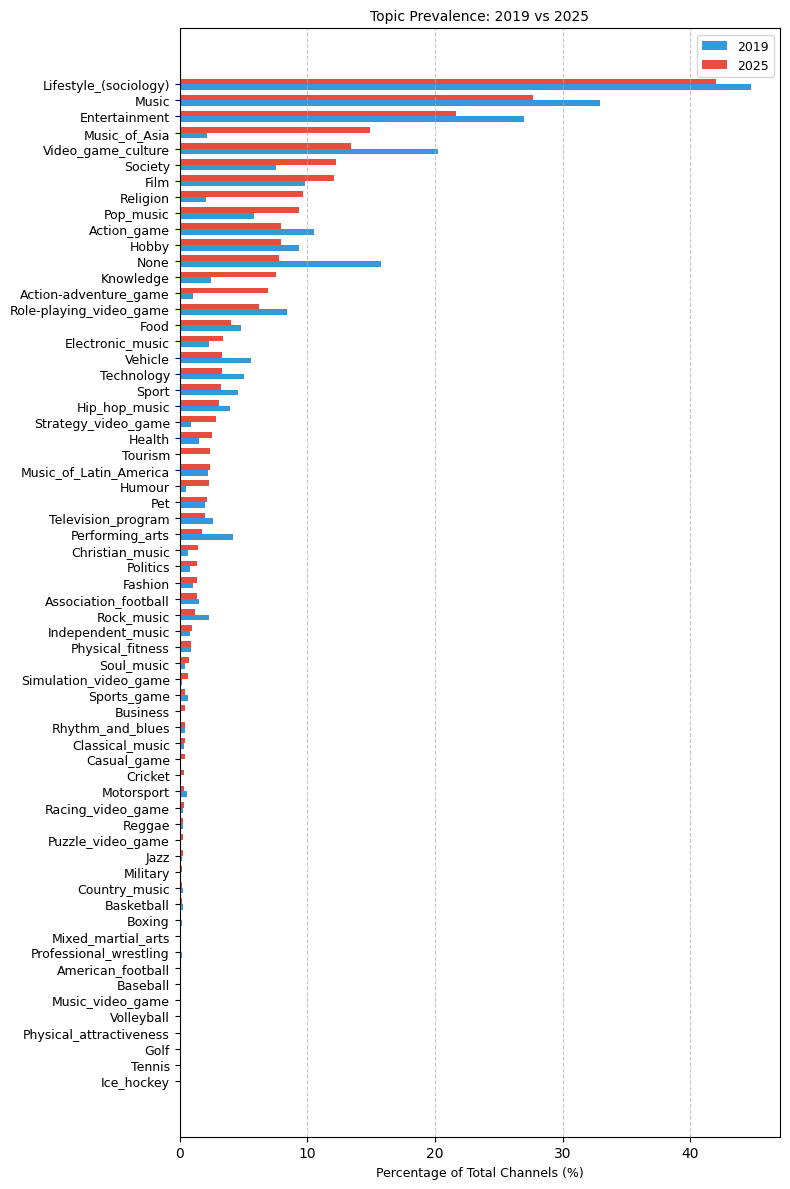

In [12]:
plt.figure(figsize=(8, 12))
y_indexes = np.arange(len(comparison_df))
bar_height = 0.35

plt.barh(y_indexes - bar_height/2, comparison_df['percentage_2019'], 
         height=bar_height, label='2019', color='#3498db')

plt.barh(y_indexes + bar_height/2, comparison_df['percentage_2025'], 
         height=bar_height, label='2025', color='#e74c3c')

plt.title(f'Topic Prevalence: 2019 vs 2025', fontsize=10)
plt.xlabel('Percentage of Total Channels (%)', fontsize=9)
plt.yticks(y_indexes, comparison_df['topic'], fontsize=9)
plt.legend(fontsize=9)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Findings:

* Fewer channels in 2025 (15.8%) do not have a wikitopic category, compared to 2019 (7.8%).
* There are some new categories (e.g., Tourism) that were not there in 2019, which raises the question of how this system has evolved in other ways.
* Many of the main categories are losing channels (e.g., Lifestyle, Entertainment, Music, Video_game_culture) while others are gaining a lot (e.g., Music_of_Asia, Society, Film, Religion), possibly again indicative of a shift towards non-Western creators and audiences.

## Temporal comparison

This is just the first attempt at looking at the "fate" of the 4.4M 1k+ channels in the 2019 dataset. There is still much more to explore.

There are also important methodological questions/limitations. Looking a the @bonbonfun channel (see below), for example: the channel stopped posting in 2023, but we are not getting it as "stopped" if we compare video numbers between 2019 and 2025. For something like this, we would need to use actual videos/video ids (NB: we have video ids for all 1k+ channels). One way to do this would be to calculate a flag like "posted in the last year", and add that to the channel database.

### Dead channels

In [14]:
total_count_2019 = con_2019.execute(f"""SELECT count(*) as channel_count FROM channels WHERE subscriberCount >= 1000""").fetchdf()["channel_count"][0]
dead_2019 = con_2025.execute(f"""SELECT count(*) as channel_count FROM channels WHERE in_2019_sample = true AND alive = false""").fetchdf()["channel_count"][0]

con_2019.close()
con_2025.execute("""ATTACH DATABASE '/Users/rieder/Desktop/YT/youtube_all_channels_2019.duckdb' AS db2019;""")

df_compare = con_2025.execute("""
    SELECT 
        c19.id,
        c19.title,
        c25.alive AS alive_2025,
        c19.subscriberCount AS subs_2019,
        c25.subscriberCount AS subs_2025,
        c19.viewCount AS views_2019,
        c25.viewCount AS views_2025,
        c19.videoCount AS videos_2019,
        c25.videoCount AS videos_2025
    FROM 
        db2019.channels AS c19
    JOIN 
        channels AS c25 ON c19.id = c25.id
    WHERE 
        c19.subscriberCount >= 1000;
""").fetchdf()

df_compare = df_compare.fillna(0)

In [15]:
print(f"Dead channels (no longer there at all) from 2019 to 2025: {dead_2019:,} of {total_count_2019:,} ({(dead_2019/total_count_2019)*100:.1f}%)")

Dead channels (no longer there at all) from 2019 to 2025: 390,435 of 4,415,180 (8.8%)


In [16]:
no_video_growth = len(df_compare[df_compare["videos_2025"] <= df_compare["videos_2019"]])

print(f"Channels with no video growth from 2019 to 2025: {no_video_growth:,} of {len(df_compare):,} ({(no_video_growth/len(df_compare))*100:.1f}%)")

Channels with no video growth from 2019 to 2025: 2,471,318 of 4,415,179 (56.0%)


In [17]:
print("Channel @bonbonfun, stopped posting in 2023:")
df_compare[df_compare["id"] == "UCesuQj-OP-zN65oHxNeMlWQ"]

Channel @bonbonfun, stopped posting in 2023:


,id,title,alive_2025,subs_2019,subs_2025,views_2019,views_2025,videos_2019,videos_2025
2945187,UCesuQj-OP-zN65oHxNeMlWQ,Nguyễn Thị Gấm Tiếp TV,True,1060,299000,1,94936597,1,108


Findings: The number of channels that have the same or lower videoCount between 2019 and 2025, is **dramatic** (56%, includes the 8.8% channels that are completely gone). Given that I may be missing some channels that stopped posting videos sometime afterwards (e.g., @bonbonfun), this is much more than I expected. I need to double and triple check this, but the data should be good.

### Growth rates

This is an attempt to quantify growth (positive or negative) for 4.4M 1k+ channels. Growth can go from -100 (e.g., going from 10 videos to 0) to +infinity (going from 0 to anything higher), but I calculate the positive values in a way to infinity does not occur (via Laplace Smoothing).

In [18]:
# growth rates with division by zero handling
#df_compare['subs_growth_rate'] = ((df_compare['subs_2025'] - df_compare['subs_2019']).div(df_compare['subs_2019'].replace(0, np.nan))  * 100).fillna(0)
#df_compare['views_growth_rate'] = ((df_compare['views_2025'] - df_compare['views_2019']).div(df_compare['views_2019'].replace(0, np.nan))  * 100).fillna(0)
#df_compare['videos_growth_rate'] = ((df_compare['videos_2025'] - df_compare['videos_2019']).div(df_compare['videos_2019'].replace(0, np.nan))  * 100).fillna(0)

# growth rates with Laplace Smoothing to avoid division by zero and zero growth rate when moving from 0 to some value
df_compare['subs_growth_rate'] = ((df_compare['subs_2025'] - df_compare['subs_2019']).div(df_compare['subs_2019'] + 1) * 100)
df_compare['views_growth_rate'] = ((df_compare['views_2025'] - df_compare['views_2019']).div(df_compare['views_2019'] + 1) * 100)
df_compare['videos_growth_rate'] = ((df_compare['videos_2025'] - df_compare['videos_2019']).div(df_compare['videos_2019'] + 1) * 100)

#df_compare.sort_values(by='videos_growth_rate', ascending=False).tail(10)
print("Sample of channels with zero views in 2019:")
df_compare[df_compare["views_2019"] == 0].sample(10)


Sample of channels with zero views in 2019:


,id,title,alive_2025,subs_2019,subs_2025,views_2019,views_2025,videos_2019,videos_2025,subs_growth_rate,views_growth_rate,videos_growth_rate
670420,UCwCQlhY2XwgEpSXWfI-4ciQ,Gustavo Freitas - Oficial,True,19500,18800,0,0,0,0,-3.6,0.0,0.0
1662367,UCFa_paUy6F2IMpUOtgZA1fg,What's Next?!!,True,45600,42400,0,0,0,0,-7.0,0.0,0.0
4177251,UCNfCM-gv2ukzDKnXUsbzjNA,Leno Pappis,True,1550,1470,0,0,0,0,-5.2,0.0,0.0
746100,UCtaVy1qSiRV4ss6Qa6oALvw,준홍2,True,1150,912,0,0,0,0,-20.7,0.0,0.0
2917016,UCqqHC1Pd1JyLH9khgpBxT4A,ScienceFact,True,5680,5040,0,0,0,0,-11.3,0.0,0.0
3452988,UCvDSEYYPzRC4t1uqdS_q1UA,VTL,True,1490,1370,0,0,0,0,-8.0,0.0,0.0
4335251,UC-oDUQhlVgFC3KqYpoe21Pw,ALEXANDRE FF,False,2190,0,0,0,0,0,-100.0,0.0,0.0
3176653,UCcve5D86Iyk33vgDG-GrUlw,Telenovelas 2018,True,1180,1090,0,0,0,0,-7.6,0.0,0.0
2106919,UCVsZa81vvSgQPPf2a-cqD4Q,G_,True,1000,970,0,0,0,0,-3.0,0.0,0.0
235138,UCCFR72FmeSPnNXpHnW8eNtg,Stod,True,2800,2630,0,5587,0,6,-6.1,"558,700.0",600.0


In [19]:
pd.options.display.float_format = '{:,.0f}'.format

print("Descriptive statistics of growth rates:")
df_compare.describe()

Descriptive statistics of growth rates:


,subs_2019,subs_2025,views_2019,views_2025,videos_2019,videos_2025,subs_growth_rate,views_growth_rate,videos_growth_rate
count,"4,415,179","4,415,179","4,415,179","4,415,179","4,415,179","4,415,179","4,415,179","4,415,179","4,415,179"
mean,"25,714","53,306","6,630,433","19,114,506",179,298,218,"9,800,833",212
std,"289,886","650,725","120,140,010","397,452,716","1,750","3,276","4,494","1,768,014,974","8,599"
min,"1,000",0,0,0,0,0,-100,-100,-100
25%,"1,530","1,630","106,800","12,168",12,4,-5,-4,-17
50%,"2,850","3,750","560,479","595,142",40,34,12,18,0
75%,"7,800","12,300","2,102,702","3,002,812",119,150,77,111,55
max,"119,000,000","442,000,000","90,251,795,729","313,520,492,555","1,067,410","2,831,836","2,677,007","1,749,930,020,200","12,944,700"


Charting growth rate distributions:


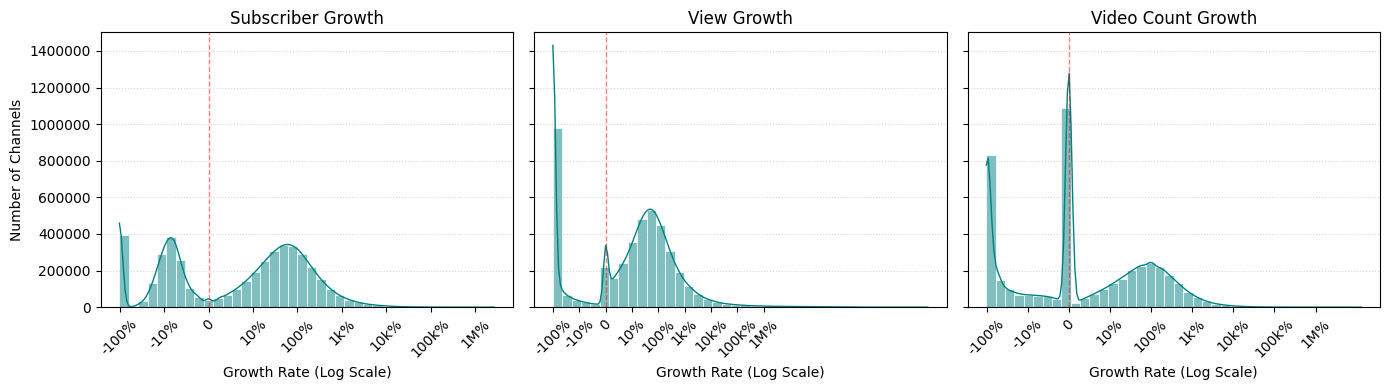

In [20]:
print("Charting growth rate distributions:")

growth_cols = ['subs_growth_rate', 'views_growth_rate', 'videos_growth_rate']
titles = ['Subscriber Growth', 'View Growth', 'Video Count Growth']

# shary applies same scales for better comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

# formatting settings for log-modulus
ticks = [-2, -1, 0, 1, 2, 3, 4, 5, 6]
labels = ["-100%", "-10%", "0", "10%", "100%", "1k%", "10k%", "100k%", "1M%"]

for i, col in enumerate(growth_cols):

    # log-modulus transform to handle negative and positive growth rates
    log_data = np.sign(df_compare[col]) * np.log10(np.abs(df_compare[col]) + 1)
    
    sns.histplot(log_data, bins=40, kde=True, ax=axes[i], color='teal', edgecolor='white', line_kws={'color': 'blue', 'linewidth': 1, 'alpha': 1})
    
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels(labels, rotation=45)
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].set_xlabel("Growth Rate (Log Scale)")
    
    axes[i].ticklabel_format(style='plain', axis='y')
    
    # vertical line at 0 for reference
    axes[i].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[i].grid(axis='y', alpha=0.5, linestyle=':')

axes[0].set_ylabel("Number of Channels")

plt.tight_layout()
plt.show()

Findings:
* Combining dead/inactive channels with growth rates, we see that more than half of the 2019 1k+ channels are either dead or inactive in 2025. NB: we do not know when the inactive channels (videoCount 2019 <= 2025) stopped posting. This may have been already before 2019, even. This needs further investigation, but the fact remains that over half of the observed channels have fewer videos in 2019 than in 2025. So a lot of the growth in videos comes from new entrants.
* We also see similar results in subscribers and views: about one half of the pack continues to grow, the other either athropies (e.g., -10% growth rate) or dies (-100% growth rate).

### Performance per channel age

This is to look at how channels are doing depending on when they were launched. It's not a direct 2019/2025 comparison, though. For the moment, I am divinding channels into age cohorts, but other analyses are possible.

In [21]:
df_daysactive = con_2025.execute("""
    SELECT daysactive, viewCount, subscriberCount, videoCount FROM channels
    WHERE in_2025_sample = true AND subscriberCount >= 1000
""").fetchdf()

df_daysactive['age_years'] = df_daysactive['daysactive'] / 365
df_daysactive['cohort'] = pd.cut(df_daysactive['age_years'], bins=[0, 1, 3, 5, 10, 25], labels=['<1y', '1-3y', '3-5y', '5-10y', '10y+']) 

In [22]:
pd.options.display.float_format = '{:,.4f}'.format
df_daysactive['consistency_score'] = df_daysactive['videoCount'] / (df_daysactive['daysactive'])
df_daysactive['view_velocity'] = df_daysactive['viewCount'] / (df_daysactive['daysactive'])

# let's create a copy of only active channels
df_active = df_daysactive[df_daysactive['consistency_score'] > 0.05].copy()

cohort_summary = df_daysactive.groupby('cohort', observed=False).agg(
    median_subs=('subscriberCount', 'median'),
    median_views=('viewCount', 'median'),
    median_videos=('videoCount', 'median'),
    median_consistency=('consistency_score', 'median'),
    median_velocity=('view_velocity', 'median'),
    channel_count=('daysactive', 'count')
)

cohort_summary["median_subs"] = cohort_summary["median_subs"].astype(int)
cohort_summary["median_views"] = cohort_summary["median_views"].astype(int)
cohort_summary["median_videos"] = cohort_summary["median_videos"].astype(int)

cohort_summary["channel_count_percent"] = (cohort_summary["channel_count"] / cohort_summary["channel_count"].sum()) * 100

cohort_summary

,median_subs,median_views,median_videos,median_consistency,median_velocity,channel_count,channel_count_percent
cohort,,,,,,,
<1y,3050,587675,82,0.4545,"3,098.0815",1105141,5.0052
1-3y,2720,410381,128,0.1785,561.1447,3663098,16.5904
3-5y,2620,359357,106,0.0731,248.0710,4181572,18.9386
5-10y,2740,318466,73,0.0287,124.2082,7666698,34.7229
10y+,2800,631896,70,0.0145,131.7020,5463165,24.7430


In [23]:
cohort_summary = df_active.groupby('cohort', observed=False).agg(
    median_subs=('subscriberCount', 'median'),
    median_views=('viewCount', 'median'),
    median_videos=('videoCount', 'median'),
    median_consistency=('consistency_score', 'median'),
    median_velocity=('view_velocity', 'median'),
    channel_count=('daysactive', 'count')
)

cohort_summary["median_subs"] = cohort_summary["median_subs"].astype(int)
cohort_summary["median_views"] = cohort_summary["median_views"].astype(int)
cohort_summary["median_videos"] = cohort_summary["median_videos"].astype(int)

cohort_summary["channel_count_percent"] = (cohort_summary["channel_count"] / cohort_summary["channel_count"].sum()) * 100

cohort_summary

,median_subs,median_views,median_videos,median_consistency,median_velocity,channel_count,channel_count_percent
cohort,,,,,,,
<1y,3150,710855,97,0.5323,"3,806.9041",994713,9.4754
1-3y,2900,561284,196,0.2750,785.0092,2791868,26.5946
3-5y,3000,611930,254,0.1765,428.8898,2430024,23.1477
5-10y,3700,724208,326,0.1301,293.6131,2933238,27.9412
10y+,4810,1374792,517,0.1095,292.1147,1348047,12.8411


Findings:
* There is a strong newcomer surge, where young <1y channels are showing very high median view and subscriber numbers. And these are lifetime numbers! This may be due to algorithmic newcomer bonus, related to shorts, or reflecting the shift towards "younger" non-Western creators and audiences.
* The youngest cohort may also be the one that has the fewest dead/inactive/decaying population that drags the others down (Survivor/Attrition Bias). The median_consistency (how consistently a channel posted over its lifetime) expresses this.
* When filtering out channels based on consistency score (< 0.05), the skew is less pronounced, but still there.

Summary: YouTube is getting faster and harder.